In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# import venn

# mu vs Ysx

In [2]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# for batch data, because at low conc, OD was more accurate
offline_data['net_biomass_cmol_from_OD'] = (offline_data["OD"]*0.28)*(offline_data["Liquid_volume"]/1000)/24.6

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [5]:
fermentation_df = pd.read_excel("../data/processed_fermentation_data/Batch_yield_mu_and_maintenance.xlsx", index_col=0)
fermentation_df

,mu_max [1/h],mu_max_std [1/h],Strain,biomass_yield_cmol_cmol_avg,biomass_yield_cmol_cmol_std
0,0.203714,NaN,SDT202,0.778595,0.058489
1,0.328765,NaN,SDT201,0.585189,0.006892
2,0.333570,NaN,SDT180,0.635257,0.079075
3,0.234722,NaN,SDT178,0.547984,0.013762
4,0.365479,NaN,SDT173,0.616048,0.000690
5,0.371367,NaN,DDB35,0.657548,0.022798


In [6]:
data_batch = fermentation_df[["mu_max [1/h]", "Strain"]]
data_batch["Phase"] = "Batch"
data_batch

data_feed = data_batch.copy()
data_feed["Phase"] = "Fed-batch"
data_feed["mu_max [1/h]"] = 0.05

mu_data = pd.concat([data_feed, data_batch])
mu_batch_data = mu_data[mu_data["Phase"] == "Batch"]
mu_batch_data

C:\Users\jonas\AppData\Local\Temp\ipykernel_19244\2581684741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_batch["Phase"] = "Batch"


,mu_max [1/h],Strain,Phase
0,0.203714,SDT202,Batch
1,0.328765,SDT201,Batch
2,0.333570,SDT180,Batch
3,0.234722,SDT178,Batch
4,0.365479,SDT173,Batch
5,0.371367,DDB35,Batch


In [7]:
offline_copy = offline_data.copy()

offline_copy['biomass_yield_cmol_cmol'] = offline_copy['net_biomass_cmol_from_OD']/offline_copy['net_glucose_cmol']
Ysx_data_batch = offline_copy[offline_copy['Timepoint (#)'] == 'S02'][["Strain", "biomass_yield_cmol_cmol"]]
Ysx_data_batch["Phase"] = "Batch"
Ysx_data_batch.head()

,Strain,biomass_yield_cmol_cmol,Phase
1,DDB35,0.648399,Batch
6,DDB35,0.651474,Batch
11,DDB35,0.676247,Batch
16,DDB35,0.645436,Batch
21,DDB35,0.649684,Batch


In [8]:
Ysx_data_batch_mean = Ysx_data_batch.groupby("Strain").mean().reset_index()
Ysx_data_batch_stdev = Ysx_data_batch.groupby("Strain").std().reset_index()

In [9]:
ysx_df = pd.merge(left=Ysx_data_batch_stdev, right=Ysx_data_batch_mean, on="Strain", suffixes=["_stedv", "_mean"], how="left")
combined_df = pd.merge(left=ysx_df, right=mu_batch_data, how="left")
combined_df.index = combined_df.Strain

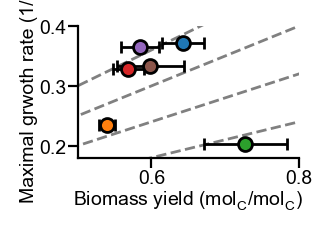

In [11]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5

### arranging the subplot
mm_per_inch = 24.5

### height and width of the actual plot
height_mm = 21
width_mm = 35

right_pad = 0
left_pad = 10
top_pad = 0
bottom_pad = 10

fig_height = height_mm+bottom_pad+top_pad
fig_width = width_mm+left_pad+right_pad

fig = plt.figure(figsize=(fig_width/mm_per_inch, fig_height/mm_per_inch), dpi=200)
spec = fig.add_gridspec(nrows=fig_height, ncols=fig_width)
# frame_ax = fig.add_subplot(spec[:,:])
frame_ax.set_xticks([])
frame_ax.set_yticks([])

ax = fig.add_subplot(spec[top_pad:fig_height-bottom_pad, left_pad:fig_width-right_pad])


for idx, strain in enumerate(["DDB35","SDT178","SDT202","SDT201","SDT173","SDT180"]):
    # print(idx,strain)
    # colors: cb_B
    
    ax.errorbar(
        x=combined_df['biomass_yield_cmol_cmol_mean'].loc[strain], 
        y=combined_df['mu_max [1/h]'].loc[strain],
        xerr=combined_df['biomass_yield_cmol_cmol_stedv'].loc[strain],
        yerr=None,
        label=strain,
        elinewidth=1,
        capsize = 2,
        fmt='.',
        markersize=10,
        ecolor = "k",
        markerfacecolor=cm.tab10(idx),
        markeredgecolor="k",
        markeredgewidth = 1
    )
    
# ax.spines["left"].set_position(("axes", -0.05))
# ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines[["top","right"]].set_visible(False);

# ax.annotate(text="WT",xy=(combined_df['biomass_yield_cmol_cmol_mean'].loc["DDB35"], combined_df['mu_max [1/h]'].loc["DDB35"]), xytext=(0.65,0.35), arrowprops=dict(arrowstyle= "-",color='k',lw=0.5,ls='-'))
# ax.annotate(text=u"\u0394"+" cra",xy=(combined_df['biomass_yield_cmol_cmol_mean'].loc["SDT178"], combined_df['mu_max [1/h]'].loc["SDT178"]), xytext=(0.55,0.215), arrowprops=dict(arrowstyle= "-",color='k',lw=0.5,ls='-'))
# ax.annotate(text=u"\u0394"+" crp",xy=(combined_df['biomass_yield_cmol_cmol_mean'].loc["SDT202"], combined_df['mu_max [1/h]'].loc["SDT202"]), xytext=(0.7,0.225), arrowprops=dict(arrowstyle= "-",color='k',lw=0.5,ls='-'))
# ax.annotate(text=u"\u0394"+" fliA",xy=(combined_df['biomass_yield_cmol_cmol_mean'].loc["SDT201"], combined_df['mu_max [1/h]'].loc["SDT201"]), xytext=(0.54,0.31), arrowprops=dict(arrowstyle= "-",color='k',lw=0.5,ls='-'))
# ax.annotate(text=u"\u0394"+" prpR",xy=(combined_df['biomass_yield_cmol_cmol_mean'].loc["SDT173"], combined_df['mu_max [1/h]'].loc["SDT173"]), xytext=(0.55,0.345), arrowprops=dict(arrowstyle= "-",color='k',lw=0.5,ls='-'))
# ax.annotate(text=u"\u0394"+" rpoS",xy=(combined_df['biomass_yield_cmol_cmol_mean'].loc["SDT180"], combined_df['mu_max [1/h]'].loc["SDT180"]), xytext=(0.6,0.315), arrowprops=dict(arrowstyle= "-",color='k',lw=0.5,ls='-'))


ax.set_ylim(bottom=0.18,top=0.4)
ax.set_xlim(left=0.5,right=0.8)

x_min = ax.get_xlim()[0]
x_max = ax.get_xlim()[1]
y_min = ax.get_ylim()[0]
y_max = ax.get_ylim()[1]

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_ylabel("Maximal grwoth rate (1/h)")
ax.set_xlabel('Biomass yield ($mol_{C}$/$mol_{C}$)')

plt.plot([0.1,1],[0.03,0.3], color="grey", linestyle="--", linewidth=1, zorder=0)
plt.plot([0.1,1],[0.04,0.4], color="grey", linestyle="--", linewidth=1, zorder=0)
plt.plot([0.1,1],[0.05,0.5], color="grey", linestyle="--", linewidth=1, zorder=0)
plt.plot([0.1,1],[0.06,0.6], color="grey", linestyle="--", linewidth=1, zorder=0);

# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# plt.savefig("test.png", dpi=600, bbox_inches="tight")

# Fermentation Timeplots

In [12]:
online_data = pd.read_excel("../data/processed_fermentation_data/scale-down_online_data.xlsx")

In [13]:
time_correction_for_plotting = (online_data['adjusted_feed_time'].max() - online_data.groupby(['Parent Culture']).max()['adjusted_feed_time']).reset_index().rename(columns={'adjusted_feed_time':'time_correction_for_plotting'})
online_data_time_corrected = pd.merge(left=online_data,right=time_correction_for_plotting,how='left')
online_data_time_corrected['adjusted_feed_time_corrected'] = np.round(online_data_time_corrected['adjusted_feed_time']+online_data_time_corrected['time_correction_for_plotting'],4)

In [14]:
online_data_time_corrected["Strain"] = online_data_time_corrected["Strain Batch"].str.split("-", expand = True)[0]

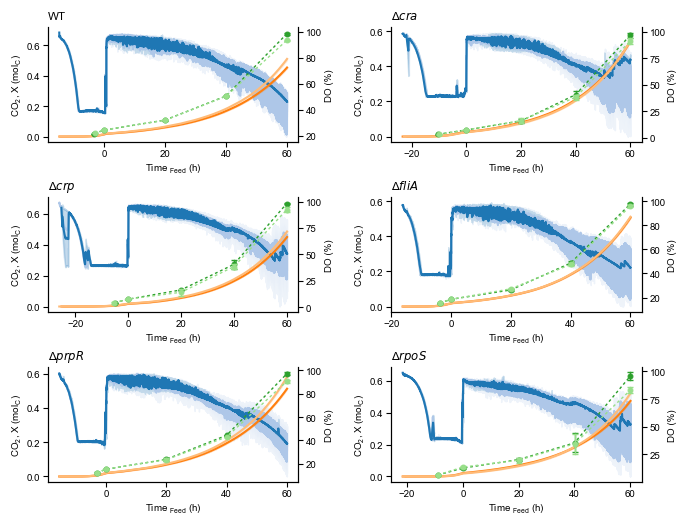

In [15]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2


fig, axes = plt.subplots(nrows=3, ncols=2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
ax5 = axes[2,0]
ax6 = axes[2,1]

strain_list = ["WT",u"\u0394"+"$\mathit{cra}$", u"\u0394"+"$\mathit{crp}$", u"\u0394"+"$\mathit{fliA}$", u"\u0394"+"$\mathit{prpR}$", u"\u0394"+"$\mathit{rpoS}$"]

for i, strain in enumerate(["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]):
    
    ax = vars()["ax"+str(i+1)]
    ax_copy = ax.twinx()
    
    if strain == "DDB35":
        data = online_data_time_corrected[online_data_time_corrected["Strain Batch"] == "DDB35-005"]
    else:
        data = online_data_time_corrected[online_data_time_corrected["Strain"] == strain]

    sns.lineplot(
        data = data[data["Condition"] == "scale-down"],
        hue="Condition",
        x="adjusted_feed_time_corrected",
        y="DO",
        ax=ax_copy,
        legend=False,
        palette=[cm.tab20(1)],
        zorder=3
    )

    sns.lineplot(
        data = data[data["Condition"] == "control"],
        hue="Condition",
        x="adjusted_feed_time_corrected",
        y="DO",
        ax=ax_copy,
        legend=False,
        palette=[cm.tab20(0)],
        zorder=7
    )
    if strain == "DDB35":
        data = online_data_time_corrected[online_data_time_corrected["Strain Batch"] == "DDB35-005"]
    else:
        data = online_data_time_corrected[online_data_time_corrected["Strain"] == strain]

    sns.lineplot(
        data = data,
        hue="Condition",
        x="adjusted_feed_time_corrected",
        y="Formed_CO2",
        ax=ax,
        legend=False,
        palette=[cm.tab20(2),cm.tab20(3)]
    )

    if strain == "DDB35":
        data = offline_data[offline_data["Strain Batch"] == "DDB35-005"]
    else:
        data = offline_data[offline_data["Strain"] == strain]

    sns.lineplot(
        ax=ax,
        data=data,
        x="average_feed_time",
        y="net_biomass_cmol",
        style='Condition',
        hue="Condition",
        palette=[cm.tab20(4),cm.tab20(5)],
        dashes=[(2, 2), (2, 2)],
        linewidth = 1,
        errorbar = 'sd',
        err_style='bars',
        err_kws = {
            'elinewidth':1.0,
            'capsize':2.0
        },
        # marker styles
        markersize=7,
        markers=['.','.'],
        markeredgecolor=None,
        legend=False
    )
    
    ax.set_ylabel("$CO_{2}$, X ($mol_{C}$)")
    ax_copy.set_ylabel("DO (%)")
    ax.set_xlabel("Time $_{Feed}$ (h)")

    ax.set_zorder(10)
    ax.patch.set_visible(False)
    ax.spines[["top"]].set_visible(False);
    ax_copy.spines[["top"]].set_visible(False)
    
    ax.set_title(strain_list[i], loc="left");
    
w=171/25.4
h=130/25.4
fig.set_size_inches(w=w,h=h)
plt.tight_layout(pad=0.3,w_pad=2)

# Ysx and Ysc Barplots for the scale-down to control comparison

## Ysx

In [17]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# for batch data, because at low conc, OD was more accurate
offline_data['net_biomass_cmol_from_OD'] = (offline_data["OD"]*0.28)*(offline_data["Liquid_volume"]/1000)/24.6

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [18]:
data_feed_S02 = offline_data[offline_data["Timepoint (#)"] == "S02"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "net_biomass_cmol_from_OD"]]
data_feed_S02 = data_feed_S02.rename(columns={"net_biomass_cmol_from_OD":"net_biomass_cmol"})
data_feed_S05 = offline_data[offline_data["Timepoint (#)"] == "S05"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "net_biomass_cmol"]]
data_feed = pd.concat([data_feed_S02, data_feed_S05])
feed_biomass_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="net_biomass_cmol")
feed_biomass_data["biomass_difference"] = feed_biomass_data["S05"] - feed_biomass_data["S02"]
feed_biomass_data = feed_biomass_data.reset_index()
feed_biomass_data = feed_biomass_data[["Parent Culture", "Strain", "Condition", "biomass_difference"]]
feed_biomass_data.columns.name = None
feed_biomass_data.head()

,Parent Culture,Strain,Condition,biomass_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,0.636644
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,0.641830
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,0.626817
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,0.593494
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,0.597327


In [19]:
data_feed = offline_data[(offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05")][["Parent Culture", "Strain", "Condition", "Timepoint (#)", "net_glucose_cmol"]]
feed_glucose_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="net_glucose_cmol")
feed_glucose_data["glucose_difference"] = feed_glucose_data["S05"] - feed_glucose_data["S02"]
feed_glucose_data = feed_glucose_data.reset_index()
feed_glucose_data = feed_glucose_data[["Parent Culture", "Strain", "Condition", "glucose_difference"]]
feed_glucose_data.columns.name = None
feed_glucose_data.head()

,Parent Culture,Strain,Condition,glucose_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,1.020044
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,1.020120
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,1.020056
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,1.019836
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,1.019988


In [20]:
data_feed = pd.merge(left=feed_biomass_data, right=feed_glucose_data, how="left")
data_feed["biomass_yield_cmol_cmol"] = data_feed["biomass_difference"]/data_feed["glucose_difference"]
data_feed = data_feed[["Strain", "Condition", "biomass_yield_cmol_cmol"]]
data_feed.head()

,Strain,Condition,biomass_yield_cmol_cmol
0,DDB35,control,0.624134
1,DDB35,control,0.629171
2,DDB35,control,0.614493
3,DDB35,scale-down,0.581950
4,DDB35,scale-down,0.585621


In [21]:
data = data_feed.copy()
df_Ysx_plotting = data.copy()

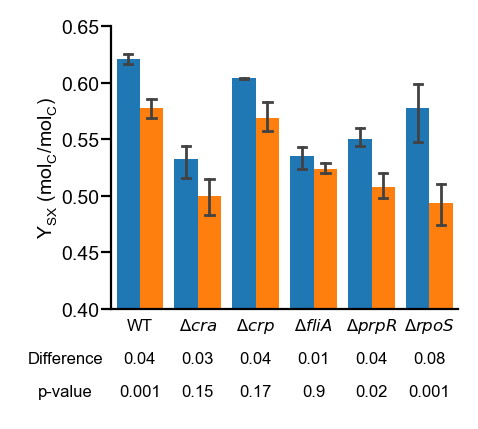

In [23]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

### height and width of the actual plot
height_mm = 45
width_mm = 55

### arranging the subplot
mm_per_inch = 24.5

right_pad = 0
left_pad = 16
top_pad = 0
bottom_pad = 16

fig_height = height_mm+bottom_pad+top_pad
fig_width = width_mm+left_pad+right_pad

fig = plt.figure(figsize=(fig_width/mm_per_inch, fig_height/mm_per_inch),dpi=200)
spec = fig.add_gridspec(nrows=fig_height, ncols=fig_width)
# frame_ax = fig.add_subplot(spec[:,:])
# frame_ax.set_xticks([])
# frame_ax.set_yticks([])

ax = fig.add_subplot(spec[top_pad:fig_height-bottom_pad, left_pad:fig_width-right_pad])

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+"$\mathit{cra}$", u"\u0394"+"$\mathit{crp}$", u"\u0394"+"$\mathit{fliA}$", u"\u0394"+"$\mathit{prpR}$", u"\u0394"+"$\mathit{rpoS}$"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.barplot(
    x="Strain_name", 
    y="biomass_yield_cmol_cmol", 
    hue="Condition",
    hue_order=["control", "scale-down"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
    errwidth=1,
    capsize=0.15,
    # fliersize=0,
    # linewidth=0.5,
    ax=ax
    # **PROPS
) 

# sns.swarmplot(
#     data=df_plotting,
#     x="Strain_name", 
#     y="biomass_yield_cmol_cmol",
#     hue="Condition",
#     hue_order=["control", "scale-down"],
#     ax=ax,
#     color="k",
#     size=2,
#     dodge=True,
#     legend=False
# )

ax.set_ylim(0.4,0.65)

ax.spines[["top","right"]].set_visible(False)
ax.set_ylabel("$Y_{SX}$ ($mol_{C}$/$mol_{C}$)");
ax.set_xlabel("");
# ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)
ax.set_xticks([])
ax.set_xticklabels([])
ax.get_legend().remove()

cellText = [["0.04", "0.03", "0.04", "0.01", "0.04", "0.08"], ["0.001", "0.15", "0.17", "0.9", "0.02", "0.001"]]

table  = ax.table(
    cellText=cellText,
    cellLoc = "center",
    rowLoc = "center",
    colLoc = "center",
    colLabels = ["WT",u"\u0394"+"$\mathit{cra}$", u"\u0394"+"$\mathit{crp}$", u"\u0394"+"$\mathit{fliA}$", u"\u0394"+"$\mathit{prpR}$", u"\u0394"+"$\mathit{rpoS}$"],
    rowLabels=["Difference","p-value"],
    edges = "open"
)

table.auto_set_font_size(False)
table.set_fontsize(6)

## Ysc

In [10]:
offline_data = pd.read_excel("../data/processed_fermentation_data/scale-down_offline_data.xlsx")

# general yield calc
offline_data['o2_yield_mol_cmol'] = offline_data['Consumed_O2']/offline_data['net_glucose_cmol']
offline_data['co2_yield_cmol_cmol'] = offline_data['Formed_CO2']/offline_data['net_glucose_cmol']
offline_data['biomass_yield_cmol_cmol'] = offline_data['net_biomass_cmol']/offline_data['net_glucose_cmol']

# Add strain name
offline_data["Strain"] = offline_data["Strain Batch"].str.split("-",expand=True)[0]

In [11]:
data_feed_S02 = offline_data[offline_data["Timepoint (#)"] == "S02"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "Formed_CO2"]]
data_feed_S05 = offline_data[offline_data["Timepoint (#)"] == "S05"][["Parent Culture", "Strain", "Timepoint (#)", "Condition", "Formed_CO2"]]
data_feed = pd.concat([data_feed_S02, data_feed_S05])
feed_biomass_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="Formed_CO2")
feed_biomass_data["CO2_difference"] = feed_biomass_data["S05"] - feed_biomass_data["S02"]
feed_biomass_data = feed_biomass_data.reset_index()
feed_biomass_data = feed_biomass_data[["Parent Culture", "Strain", "Condition", "CO2_difference"]]
feed_biomass_data.columns.name = None
feed_biomass_data.head()

,Parent Culture,Strain,Condition,CO2_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,0.431051
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,0.436409
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,0.439439
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,0.496892
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,0.491544


In [12]:
data_feed = offline_data[(offline_data["Timepoint (#)"] == "S02") | (offline_data["Timepoint (#)"] == "S05")][["Parent Culture", "Strain", "Condition", "Timepoint (#)", "net_glucose_cmol"]]
feed_glucose_data = data_feed.pivot(index=["Parent Culture", "Strain", "Condition"], columns="Timepoint (#)", values="net_glucose_cmol")
feed_glucose_data["glucose_difference"] = feed_glucose_data["S05"] - feed_glucose_data["S02"]
feed_glucose_data = feed_glucose_data.reset_index()
feed_glucose_data = feed_glucose_data[["Parent Culture", "Strain", "Condition", "glucose_difference"]]
feed_glucose_data.columns.name = None
feed_glucose_data.head()

,Parent Culture,Strain,Condition,glucose_difference
0,DDB_PD_117_AMBR_DDB35-005_R05_Main_,DDB35,control,1.020044
1,DDB_PD_117_AMBR_DDB35-005_R06_Main_,DDB35,control,1.020120
2,DDB_PD_117_AMBR_DDB35-005_R07_Main_,DDB35,control,1.020056
3,DDB_PD_117_AMBR_DDB35-005_R08_Main_,DDB35,scale-down,1.019836
4,DDB_PD_117_AMBR_DDB35-005_R09_Main_,DDB35,scale-down,1.019988


In [13]:
data_feed = pd.merge(left=feed_biomass_data, right=feed_glucose_data, how="left")
data_feed["co2_yield_cmol_cmol"] = data_feed["CO2_difference"]/data_feed["glucose_difference"]
data_feed = data_feed[["Strain", "Condition", "co2_yield_cmol_cmol"]]
data_feed.head()

,Strain,Condition,co2_yield_cmol_cmol
0,DDB35,control,0.422581
1,DDB35,control,0.427801
2,DDB35,control,0.430799
3,DDB35,scale-down,0.487227
4,DDB35,scale-down,0.481911


In [14]:
data = data_feed.copy()
df_Ysc_plotting = data.copy()

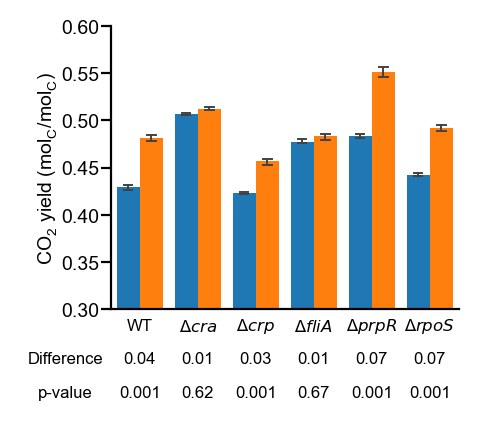

In [15]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 0.5
plt.rcParams['ytick.major.pad']= 0.5

plt.rcParams['axes.labelpad']= 0.5
# plt.rcParams['ylabel.pad']= 0

### height and width of the actual plot
height_mm = 45
width_mm = 55

fig, ax = plt.subplots(figsize=(width_mm/mm_per_inch, height_mm/mm_per_inch), dpi=200)

df_plotting = data.copy()

order_df = pd.DataFrame()
order_df["Strain"] = ["DDB35", "SDT178", "SDT202", "SDT201", "SDT173", "SDT180"]
order_df["Strain_name"] = ["WT",u"\u0394"+"$\mathit{cra}$", u"\u0394"+"$\mathit{crp}$", u"\u0394"+"$\mathit{fliA}$", u"\u0394"+"$\mathit{prpR}$", u"\u0394"+"$\mathit{rpoS}$"]
order_df["order"]  = [1,2,3,4,5,6]

df_plotting = pd.merge(left=df_plotting,right=order_df,how="left")
df_plotting = df_plotting.sort_values("order")

PROPS = {
    'boxprops':{'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

sns.barplot(
    x="Strain_name", 
    y="co2_yield_cmol_cmol", 
    hue="Condition",
    hue_order=["control", "scale-down"],
    data=df_plotting, 
    palette="tab10",
    saturation=1,
    errwidth=0.7,
    capsize=0.15,
    # fliersize=0,
    # linewidth=0.5,
    ax=ax
    # **PROPS
) 

# sns.swarmplot(
#     data=df_plotting,
#     x="Strain_name", 
#     y="biomass_yield_cmol_cmol",
#     hue="Condition",
#     hue_order=["control", "scale-down"],
#     ax=ax,
#     color="k",
#     size=2,
#     dodge=True,
#     legend=False
# )

ax.set_ylim(0.3,0.6)

ax.spines[["top","right"]].set_visible(False)
ax.set_ylabel("$CO_{2}$ yield ($mol_{C}$/$mol_{C}$)");
ax.set_xlabel("");
# ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=40)
ax.set_xticklabels([])
ax.set_xticks([])
ax.get_legend().remove()

cellText = [["0.04", "0.01", "0.03", "0.01", "0.07", "0.07"], ["0.001", "0.62", "0.001", "0.67", "0.001", "0.001"]]

table  = ax.table(
    cellText=cellText,
    cellLoc = "center",
    rowLoc = "center",
    colLoc = "center",
    colLabels = ["WT",u"\u0394"+"$\mathit{cra}$", u"\u0394"+"$\mathit{crp}$", u"\u0394"+"$\mathit{fliA}$", u"\u0394"+"$\mathit{prpR}$", u"\u0394"+"$\mathit{rpoS}$"],
    rowLabels=["Difference","p-value"],
    edges = "open"
)

table.auto_set_font_size(False)
table.set_fontsize(6)